In [1]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

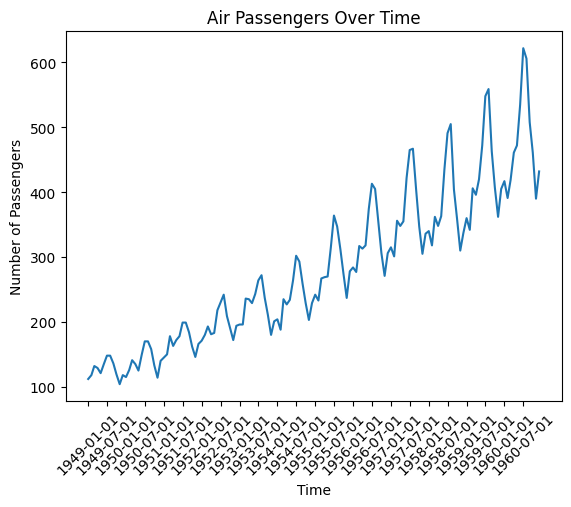

In [2]:
# Load the dataset
data = pd.read_csv('kaggle/air_passengers.csv', parse_dates=['Month'], index_col='Month')

plt.plot(data)
plt.title('Air Passengers Over Time')
plt.xlabel('Time')
plt.xticks(data.index[::6], rotation=45)
plt.ylabel('Number of Passengers')
plt.show()

# Normalize the dataset
scaler = MinMaxScaler(feature_range=(-1, 1))
data_normalized = scaler.fit_transform(data.values.reshape(-1, 1))

In [3]:
data_normalized = torch.FloatTensor(data_normalized).view(-1)

# Define a function to create sequences
def create_inout_sequences(input_data, tw):
    inout_seq = []
    L = len(input_data)
    # Create a sequence of tw elements and the next element as the label
    for i in range(L-tw):
        # Create a sequence of tw elements
        train_seq = input_data[i:i+tw]
        # The next element is the label
        train_label = input_data[i+tw:i+tw+1]
        inout_seq.append((train_seq, train_label))
    return inout_seq

# Create sequences
seq_length = 12  # Using 12 months of data to predict the next month
sequences = create_inout_sequences(data_normalized, seq_length)

In [4]:
class RNNModel(nn.Module):
    def __init__(self, input_size=1, hidden_layer_size=100, output_size=1):
        super().__init__()
        self.hidden_layer_size = hidden_layer_size
        # Define the RNN layer
        self.rnn = nn.RNN(input_size, hidden_layer_size)
        # Define the output layer
        self.linear = nn.Linear(hidden_layer_size, output_size)

    def forward(self, input_seq):
        # Initialize the hidden state
        rnn_out, _ = self.rnn(input_seq.view(len(input_seq), 1, -1))
        # Get the last element of the sequence
        predictions = self.linear(rnn_out.view(len(input_seq), -1))
        return predictions[-1]

In [5]:
# Define training parameters
model = RNNModel()
loss_function = nn.MSELoss()
# Using the Adam optimizer, which is a combination of RMSprop and 
# Stochastic Gradient Descent
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

epochs = 100

# Training loop
for i in range(epochs):
    for seq, labels in sequences:
        optimizer.zero_grad()
        model.hidden_cell = (
            torch.zeros(1, 1, model.hidden_layer_size),
            torch.zeros(1, 1, model.hidden_layer_size)
        )

        y_pred = model(seq)

        single_loss = loss_function(y_pred, labels)
        single_loss.backward()
        optimizer.step()

    if i%25 == 0 or i == epochs-1:
        print(f'epoch: {i:3d} loss: {single_loss.item():.12f}')

epoch:   0 loss: 0.036085028201
epoch:  25 loss: 0.000542427239
epoch:  50 loss: 0.008391734213
epoch:  75 loss: 0.003658861388
epoch:  99 loss: 0.000292083132


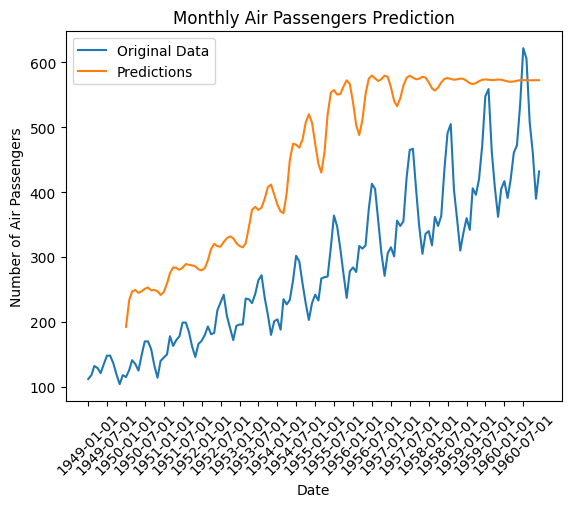

In [6]:
# Make predictions
model.eval()
for i in range(len(data) - seq_length):
    seq = data_normalized[i:i+seq_length]
    with torch.no_grad():
        data_normalized[i+seq_length] = model(seq)

# Inverse transform to original scale
data_predicted = scaler.inverse_transform(data_normalized.reshape(-1, 1).numpy())

# Plot the results
plt.plot(data.index, data.values, label='Original Data')
plt.plot(data.index[seq_length:], data_predicted[seq_length:], label='Predictions')
plt.title('Monthly Air Passengers Prediction')
plt.xlabel('Date')
plt.xticks(data.index[::6], rotation=45)
plt.ylabel('Number of Air Passengers')
plt.legend()
plt.show()